In [34]:
import os
smoke_test = ('CI' in os.environ)  # for continuous integration tests

# various import statements
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
from torch.nn.functional import softplus, softmax, sigmoid
from torch.distributions import constraints
from torch.optim import Adam
import torch.nn.functional as F

from torch.autograd import Variable
from torch.autograd.functional import jacobian

from torchdiffeq import odeint_adjoint as odeint

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions.util import broadcast_shape
from pyro.optim import MultiStepLR
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO
from pyro.contrib.examples.scanvi_data import get_data

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import scvelo as scv
import scanpy as sc
adata = scv.datasets.bonemarrow()
# Define the cell type you want to remove
cell_type_to_remove = 'CLP'

# Filter out cells belonging to the specified cell type
adata= adata[adata.obs['clusters'] != cell_type_to_remove]
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
# scv.pp.neighbors(adata, n_neighbors=30)
spliced_library_size = adata.layers['spliced'].sum(axis=1)
unspliced_library_size = adata.layers['unspliced'].sum(axis=1)
temp_adata = adata.copy()
scv.pp.filter_and_normalize(temp_adata, min_shared_counts=20, n_top_genes=2000)
sc.pp.log1p(temp_adata)
adata.layers['lognormalized_unspliced'] = temp_adata.layers['unspliced']
adata.layers['lognormalized_spliced'] = temp_adata.layers['spliced']
norm_unspliced_tensor = torch.from_numpy(adata.layers['lognormalized_unspliced'].toarray()).type(torch.float32)
norm_spliced_tensor =  torch.from_numpy(adata.layers['lognormalized_spliced'].toarray()).type(torch.float32)
spliced_tensor = torch.from_numpy(adata.layers['spliced'].toarray().astype(np.float32)).type(torch.float32)
unspliced_tensor = torch.from_numpy(adata.layers['unspliced'].toarray().astype(np.float32)).type(torch.float32)

Filtered out 7875 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/home/arataz/NDE/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [36]:
# Helper for making fully-connected neural networks
def make_fc(dims):
    layers = []
    for in_dim, out_dim in zip(dims, dims[1:]):
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(nn.BatchNorm1d(out_dim))
        layers.append(nn.Softplus())
    return nn.Sequential(*layers[:-1])  # Exclude final Softplus non-linearity
# Splits a tensor in half along the final dimension
def split_in_half(t):
    return t.reshape(t.shape[:-1] + (2, -1)).unbind(-2)
# Used in parameterizing p(s | z2)
class XDecoder(nn.Module):
    # This __init__ statement is executed once upon construction of the neural network.
    # Here we specify that the neural network has input dimension z2_dim
    # and output dimension num_genes.
    def __init__(self, num_genes, z_dim, hidden_dims):
        super().__init__()
        # Create a list to store the layers
        dims = [z_dim] + hidden_dims + [2 * num_genes]
        self.fc = make_fc(dims)
    # This method defines the actual computation of the neural network. It takes
    # z2 as input and spits out two parameters that are then used in the model
    # to define the ZINB observation distribution. In particular it generates
    # `gate_logits`, which controls zero-inflation, and `mu` which encodes the
    # relative frequencies of different genes.
    def forward(self, z):
        gate, mu = split_in_half(self.fc(z))
        # Note that mu is normalized so that total count information is
        # encoded by the latent variable ℓ.
        mu = softmax(mu, dim=-1)
        # gate = sigmoid(gate)
        return gate, mu
    
# Used in parameterizing q(sl | s)
class LEncoder(nn.Module):
    def __init__(self, num_genes, hidden_dims):
        super().__init__()
        dims = [num_genes] + hidden_dims + [2]
        self.fc = make_fc(dims)

    def forward(self, s):
        # Transform the counts x to log space for increased numerical stability.
        # Note that we only use this transformation here; in particular the observation
        # distribution in the model is a proper count distribution.
        l_loc, l_scale = split_in_half(self.fc(s))
        l_scale = softplus(l_scale)
        return l_loc, l_scale
# Used in parameterizing p(z2 | z1, s)
class XEncoder(nn.Module):
    def __init__(self, z_dim,num_genes, hidden_dims):
        super().__init__()
        dims = [2* num_genes] + hidden_dims + [2 * z_dim + 2]
        self.fc = make_fc(dims)
        self.sigmoid = nn.Sigmoid()
    def forward(self, u, s):
        u = u.type(torch.float32)
        s = s.type(torch.float32)
        x = torch.cat([s, u], dim=-1)
        # We reshape the input to be two-dimensional so that nn.BatchNorm1d behaves correctly
        x = x.reshape(-1, x.size(-1))
        hidden = self.fc(x)
        # If the input was three-dimensional we now restore the original shape
        hidden = hidden.reshape(x.shape[:-1] + hidden.shape[-1:])
        # t = hidden[...,-1]
        # hidden = hidden[...,:-1]
        loc, scale = split_in_half(hidden)
        loc_z = loc[... , :-1]
        loc_t = loc[... ,-1]
        scale_z = scale[... , :-1]
        scale_t = scale[... ,-1]
        
        # Here and elsewhere softplus ensures that scale is positive. Note that we generally
        # expect softplus to be more numerically stable than exp.
        scale_z = softplus(scale_z)
        scale_t = softplus(scale_t)
        loc_t = self.sigmoid(loc_t)
        return loc_z, scale_z, loc_t, scale_t
class ODEFunc(nn.Module):
    def __init__(self,z_dim = 10):
        super().__init__()
        self.latent_dim = z_dim
        self.f = nn.Sequential(
            nn.Linear(self.latent_dim, self.latent_dim),
            nn.Softplus(),
            nn.Linear(self.latent_dim, self.latent_dim),
            nn.Softplus(),
            nn.Linear(self.latent_dim, self.latent_dim)
            )

    def forward(self, t, y):
        
        return self.f(y)


def prepare_vae(adata, mse_weight = 1, batch_size=128):
    num_genes = len(adata.var)

    # Calculate library size (total counts) for each cell
    spliced_library_size = np.log(adata.layers['spliced'].sum(axis=1))

    # Calculate mean and scale for spliced layer
    sl_mean = spliced_library_size.mean()
    sl_scale = spliced_library_size.std()

    # Calculate library size for unspliced layer
    unspliced_library_size = np.log(adata.layers['unspliced'].sum(axis=1))

    # Calculate mean and scale for unspliced layer
    ul_mean = unspliced_library_size.mean()
    ul_scale = unspliced_library_size.std()

    # Instantiate instance of model/guide and various neural networks
    vae = VAE(num_genes=num_genes,
              sl_loc=sl_mean, sl_scale=sl_scale, ul_loc=ul_mean, ul_scale=ul_scale, mse_weight = mse_weight,
              scale_factor=1.0 / (batch_size * num_genes))

    return vae


def calc_mse (z,t,vae):
    index = torch.argsort(t)
    original_index = torch.argsort(index)
    t_ode = t[index]
    IC = z[index][0]
    z_hat = odeint(vae.ode_func, IC, t_ode).squeeze()
    z_hat = z_hat[original_index]
    mse = nn.MSELoss()
    return mse(z, z_hat).item()


from tqdm import tqdm
def train_vae(adata, mse_weight = 1, num_epochs=80,batch_size = 128, smoke_test=False):
    # Clear Pyro param store so we don't conflict with previous
    # training runs in this session
    pyro.clear_param_store()

    # Fix random number seed
    pyro.util.set_rng_seed(42)

    # Enable optional validation warnings
    pyro.enable_validation(True)

    dataset = TensorDataset(spliced_tensor, unspliced_tensor, norm_spliced_tensor, norm_unspliced_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_genes = len(adata.var)
    vae = prepare_vae(adata, mse_weight, batch_size)
    if not smoke_test:
        if torch.cuda.is_available():
            # Use GPU (CUDA)
            device = torch.device("cuda")
        else:
            # Use CPU
            device = torch.device("cpu")
        vae = vae.to(device)
     # Setup an optimizer (Adam) and learning rate scheduler.
    # We start with a moderately high learning rate (0.006) and
    # reduce by a factor of 5 after 20 epochs.
    scheduler = MultiStepLR({'optimizer': Adam,
                             'optim_args': {'lr': 0.006},
                             'gamma': 0.2, 'milestones': [5]},
                              {"clip_norm": 10.0})

    # Setup a variational objective for gradient-based learning.
    # Note we use TraceEnum_ELBO in order to leverage Pyro's machinery
    # for automatic enumeration of the discrete latent variable y.
    elbo = TraceEnum_ELBO(strict_enumeration_warning=False)
    svi = SVI(vae.model, vae.guide, scheduler, elbo)

    # Training loop.
    # We train for num_epochs epochs.
    # For optimal results, tweak the optimization parameters.
    # For our purposes, 80 epochs of training is sufficient.
    # Training should take about 8 minutes on a GPU-equipped Colab instance.

    losses = []

    for epoch in range(num_epochs):
        epoch_losses = []
        l2_losses = []

        # Take a gradient step for each mini-batch in the dataset
        for s_raw, u_raw, s ,u in tqdm(data_loader, desc=f'Epoch {epoch}'):
            s_raw, u_raw, s, u = s_raw.to(device), u_raw.to(device), s.to(device), u.to(device)
            loss = svi.step(u_raw, s_raw, u, s)
            epoch_losses.append(loss)
            enc = vae.x_encoder(u, s)
            z = pyro.sample("z", dist.Normal(enc[0], enc[1]).to_event(1))
            t = pyro.sample("t", dist.Normal(enc[2], enc[3]).to_event(0))
            l2loss = calc_mse(z,t,vae)
            l2_losses.append(l2loss)

        # Tell the scheduler we've done one epoch.
        scheduler.step()

        
        plt.figure(figsize=(10, 5))
        plt.plot(l2_losses, label='L2 Loss')
        plt.xlabel('Iter')
        plt.ylabel('ODE L2 Loss')
        plt.legend()
        plt.title('L2 Loss Over Epochs')
        plt.show()
        epoch_loss_mean = np.mean(epoch_losses)
        losses.append(epoch_loss_mean)

        if epoch%1 ==0:
            print(f"[Epoch {epoch}]  Loss: {epoch_loss_mean:.5f}")


    print("Finished training!")

    # Plot the loss function
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.close() 

    return vae


In [37]:
if torch.cuda.is_available():
    # Use GPU (CUDA)
    device = torch.device("cuda")
else:
    # Use CPU
    device = torch.device("cpu")

In [38]:
def process_data_and_save(lambda_coef, data, trained_vae, device, tsne = False):
    adata = data
    # Define the path where you want to create the folder
    folder_path = "results"

    # Create a folder name based on lambda_coef
    folder_name = f"lambda_{lambda_coef}"

    # Join the folder name with the path
    folder_full_path = os.path.join(folder_path, folder_name)

    # Create the folder if it doesn't exist
    if not os.path.exists(folder_full_path):
        os.makedirs(folder_full_path)
        print(f"Folder '{folder_name}' created successfully at '{folder_full_path}'.")
    else:
        print(f"Folder '{folder_name}' already exists at '{folder_full_path}'.")
        
    # Train VAE
    trained_vae.eval()

    # Get latent representations
    unspliced_tensor = torch.tensor(adata.layers['lognormalized_unspliced'].toarray())
    spliced_tensor = torch.tensor(adata.layers['lognormalized_spliced'].toarray())
    enc = trained_vae.x_encoder(unspliced_tensor.to(device), spliced_tensor.to(device))
    latent_rep = pyro.sample("z", dist.Normal(enc[0], enc[1]).to_event(1))
    # latent_rep = enc[0]
    adata.obsm["latent_rep"] = latent_rep.data.cpu().numpy()

    # Get time information
    # t = enc[2]
    t = pyro.sample("t", dist.Normal(enc[2], enc[3]).to_event(0))
    adata.obs["time"] = t.data.cpu().numpy()

    # Get velocity
    velocity = trained_vae.ode_func(t=None, y=latent_rep)
    adata.obsm['Neural_velocity'] = velocity.data.cpu().numpy()

    # Create a new AnnData object
    test = sc.AnnData()
    var = [i for i in range(10)]
    test.var["latent_features"] = var
    test.obs['clusters'] = adata.obs["clusters"]
    test.obs['time'] = adata.obs["time"]
    test.layers["latent_rep"] = adata.obsm["latent_rep"]
    test.obsm["latent_rep"] = adata.obsm["latent_rep"]
    test.layers["velocity"] = adata.obsm['Neural_velocity']
    
    if tsne == False:
        # Update neighbors and UMAP with latent representations
        sc.pp.neighbors(test, use_rep="latent_rep")
        sc.tl.umap(test)
        scv.tl.velocity_graph(test, vkey='velocity', xkey="latent_rep")

        # Save figures and data
        plot_filename = "time.png"
        plot_full_path = os.path.join(folder_full_path, plot_filename)
        sc.pl.tsne(adata, color='time', legend_loc='on data', show=False)
        plt.savefig(plot_full_path)

        plot_filename = "embedding.png"
        plot_full_path = os.path.join(folder_full_path, plot_filename)
        sc.pl.umap(test, color='clusters', legend_loc='on data')
        plt.savefig(plot_full_path)

        plot_filename = "New_time.png"
        plot_full_path = os.path.join(folder_full_path, plot_filename)
        sc.pl.umap(test, color='time', legend_loc='on data')
        plt.savefig(plot_full_path)

        plot_filename = "velocity.png"
        plot_full_path = os.path.join(folder_full_path, plot_filename)
        scv.pl.velocity_embedding_stream(test, basis='umap')
        plt.savefig(plot_full_path)
    if tsne == True:
        sc.pp.neighbors(adata,use_rep="latent_rep", n_neighbors=10) 
        sc.tl.tsne(test)
        scv.tl.velocity_graph(test, vkey='velocity', xkey="latent_rep")

        # Save figures and data
        plot_filename = "time.png"
        plot_full_path = os.path.join(folder_full_path, plot_filename)
        sc.pl.tsne(adata, color='time', legend_loc='on data', show=False)
        plt.savefig(plot_full_path)

        plot_filename = "embedding.png"
        plot_full_path = os.path.join(folder_full_path, plot_filename)
        sc.pl.tsne(test, color='clusters', legend_loc='on data')
        plt.savefig(plot_full_path)

        plot_filename = "New_time.png"
        plot_full_path = os.path.join(folder_full_path, plot_filename)
        sc.pl.tsne(test, color='time', legend_loc='on data')
        plt.savefig(plot_full_path)

        plot_filename = "velocity.png"
        plot_full_path = os.path.join(folder_full_path, plot_filename)
        scv.pl.velocity_embedding_stream(test, basis='tsne')
        plt.savefig(plot_full_path)

    file_filename = "data.h5ad"
    file_full_path = os.path.join(folder_full_path, file_filename)
    sc.write(file_full_path, test)
    vae_filename = "trained_vae.pt"
    vae_full_path = os.path.join(folder_full_path, vae_filename)
    torch.save(trained_vae.state_dict(), vae_full_path)

In [ ]:
def find_smallest_divisor_geq_32(n):
    """
    Find the smallest divisor d of n such that d >= 32.
    """
    for i in range(32, n + 1):
        if n % i == 0:
            return i

In [39]:
class VAE(nn.Module):
    def __init__(self, num_genes, sl_loc, sl_scale, ul_loc, ul_scale,
                 latent_dim=10, mse_weight = 1, scale_factor=1.0):
        self.num_genes = num_genes

        # This is the dimension of both z1 and z2
        self.latent_dim = latent_dim

        # The next two hyperparameters determine the prior over the log_count latent variable `l`
        self.ul_loc = ul_loc
        self.ul_scale = ul_scale
        self.sl_loc = sl_loc
        self.sl_scale = sl_scale

        # This hyperparameter controls the strength of the auxiliary classification loss
        # self.alpha = alpha
        self.scale_factor = scale_factor

        super().__init__()

        # Setup the various neural networks used in the model and guide
        self.x_encoder = XEncoder(z_dim=self.latent_dim, num_genes=self.num_genes,
                                    hidden_dims=[128 , 64])
        self.u_decoder = XDecoder(num_genes=num_genes, hidden_dims=[64, 128], z_dim=self.latent_dim)
        self.s_decoder = XDecoder(num_genes=num_genes, hidden_dims=[64, 128], z_dim=self.latent_dim)
        self.sl_encoder = LEncoder(num_genes=num_genes, hidden_dims=[64 , 32])
        self.ul_encoder = LEncoder(num_genes=num_genes, hidden_dims=[64 , 32])
        self.ode_func = ODEFunc(z_dim =  self.latent_dim)
        self.mse_weight = mse_weight
        self.epsilon = 0.003


    def model(self, u_raw, s_raw, u, s):
        # Register various nn.Modules (i.e. the decoder/encoder networks) with Pyro
        pyro.module("VAE", self)

        # This gene-level parameter modulates the variance of the observation distribution
        theta_u = pyro.param("inverse_dispersion_unspliced", 1000.0 * u_raw.new_ones(self.num_genes),
                           constraint=constraints.positive)
        theta_s = pyro.param("inverse_dispersion_spliced", 1000.0 * s_raw.new_ones(self.num_genes),
                           constraint=constraints.positive)

        # We scale all sample statements by scale_factor so that the ELBO loss function
        # is normalized wrt the number of datapoints and genes.
        # This helps with numerical stability during optimization.
        with pyro.plate("batch", len(u)), poutine.scale(scale=self.scale_factor):
            z = pyro.sample("z", dist.Normal(0, u.new_ones(self.latent_dim)).to_event(1))
            t = pyro.sample("t", dist.Normal(torch.zeros(1).cuda(),torch.ones(1).cuda()).to_event(0))
            # t = pyro.sample("t", dist.Normal(torch.zeros(1),torch.ones(1)).to_event(0))
            index = torch.argsort(t) #.squeeze()??
            original_index = torch.argsort(index)
            t_sorted = t[index]
            z_sorted = z[index]
            
            # find a divisor of the batch size that is greater than or equal to 32
            batch_size = len(z)
            divisor = find_smallest_divisor_geq_32(batch_size)

            # split the OG batch into chunks
            z_chunks = torch.chunk(z, batch_size // divisor)
            t_chunks = torch.chunk(t, batch_size // divisor) #.squeeze()??

            # stack the chunks
            ICs = torch.stack([z_chunk[0] for z_chunk in z_chunks])
            t_batches = torch.stack(t_chunks)

            #do the ode solve over the chunks stacked and then refomulate the original batch
            z_hat_batches = odeint(self.ode_func, ICs, t_batches).squeeze()
            z_hat = z_hat_batches.view(-1, z_hat_batches.size(-1))
            z_hat = z_hat[original_index]

            l1_loss_fn = nn.L1Loss()
            mse_loss_fn = nn.MSELoss()
            l1_loss = l1_loss_fn(z_hat, z)
            mse_loss = mse_loss_fn(z_hat, z)
            
            
            gate_logits_u, mu_u = self.u_decoder(z)
            ul_scale = self.ul_scale * u.new_ones(1)
            ul = pyro.sample("ul", dist.LogNormal(self.ul_loc, ul_scale).to_event(1))
            rate_u = (ul * mu_u + self.epsilon).log() - (theta_u + self.epsilon).log()
            u_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits_u, total_count=theta_u,
                                                       logits=rate_u)
            pyro.sample("u", u_dist.to_event(1), obs=u_raw)


            sl_scale = self.sl_scale * s.new_ones(1)
            sl = pyro.sample("sl", dist.LogNormal(self.sl_loc, sl_scale).to_event(1))
            # Note that by construction mu is normalized (i.e. mu.sum(-1) == 1) and the
            # total scale of counts for each cell is determined by `l`
            gate_logits_s, mu_s = self.s_decoder(z)
            rate_s = (sl * mu_s + self.epsilon).log() - (theta_s + self.epsilon).log()
            s_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits_s, total_count=theta_s,
                                                       logits=rate_s)
            pyro.sample("s", s_dist.to_event(1), obs=s_raw)
            
            
            
            gate_logits_u_hat, mu_u_hat = self.u_decoder(z_hat)
            rate_u_hat = (ul * mu_u_hat + self.epsilon).log() - (theta_u + self.epsilon).log()
            u_hat_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits_u_hat, total_count=theta_u,
                                                       logits=rate_u_hat)
            pyro.sample("u_hat", u_hat_dist.to_event(1), obs=u_raw)

            

            gate_logits_s_hat, mu_s_hat = self.s_decoder(z_hat)
            rate_s_hat = (sl * mu_s_hat + self.epsilon).log() - (theta_s + self.epsilon).log()
            s_hat_dist = dist.ZeroInflatedNegativeBinomial(gate_logits=gate_logits_s_hat, total_count=theta_s,
                                                       logits=rate_s_hat)
            # Observe the datapoint x using the observation distribution x_dist
            pyro.sample("s_hat", s_hat_dist.to_event(1), obs=s_raw)
            
            pyro.factor('L1_Loss', -torch.exp(self.mse_weight*l1_loss))
            

    # The guide specifies the variational distribution
    def guide(self, u_raw, s_raw, u , s):
        pyro.module("VAE", self)
        with pyro.plate("batch", len(u)), poutine.scale(scale=self.scale_factor):
            z_loc , z_scale, t_loc, t_scale = self.x_encoder(u,s)
            sl_loc, sl_scale = self.sl_encoder(s)
            pyro.sample("sl", dist.LogNormal(sl_loc, sl_scale).to_event(1))
            pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            pyro.sample("t", dist.Normal(t_loc, t_scale).to_event(0))
            ul_loc, ul_scale = self.ul_encoder(u)
            pyro.sample("ul", dist.LogNormal(ul_loc, ul_scale).to_event(1))

Epoch 0: 100%|██████████| 662/662 [02:53<00:00,  3.81it/s]


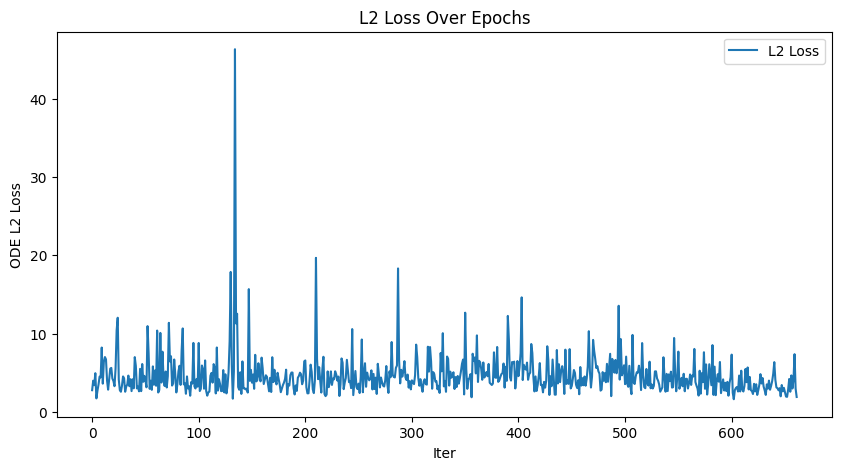

[Epoch 0]  Loss: 5.12054


Epoch 1: 100%|██████████| 662/662 [03:20<00:00,  3.31it/s]


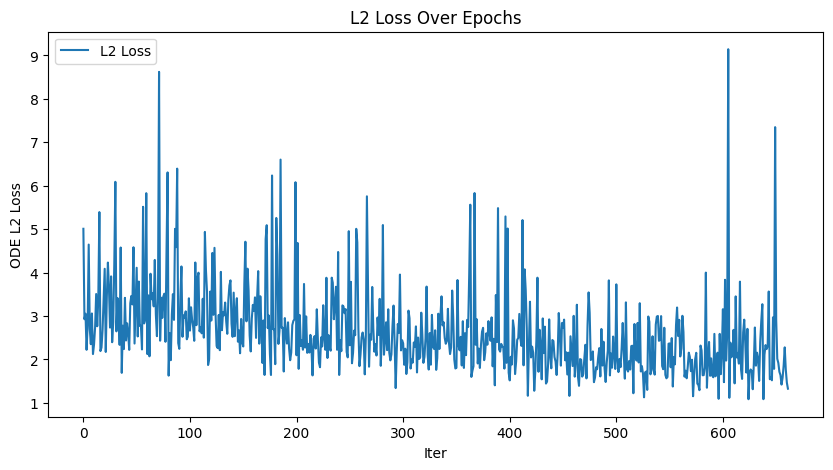

[Epoch 1]  Loss: 2.71067


Epoch 2: 100%|██████████| 662/662 [03:19<00:00,  3.33it/s]


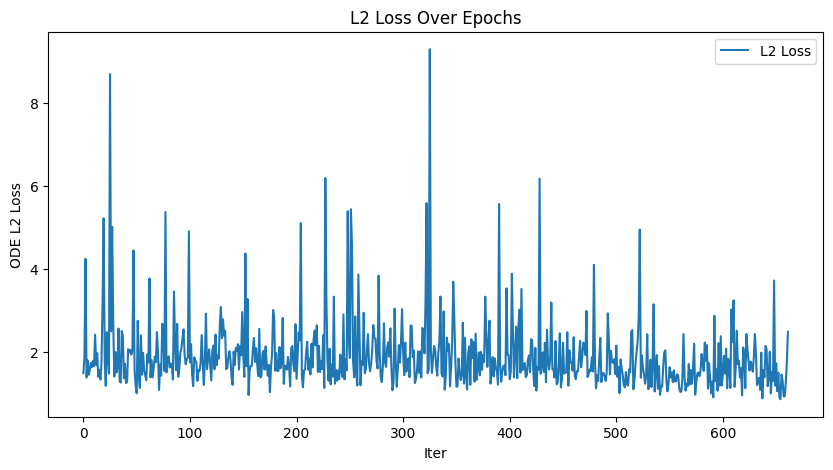

[Epoch 2]  Loss: 2.37653


Epoch 3: 100%|██████████| 662/662 [03:19<00:00,  3.32it/s]


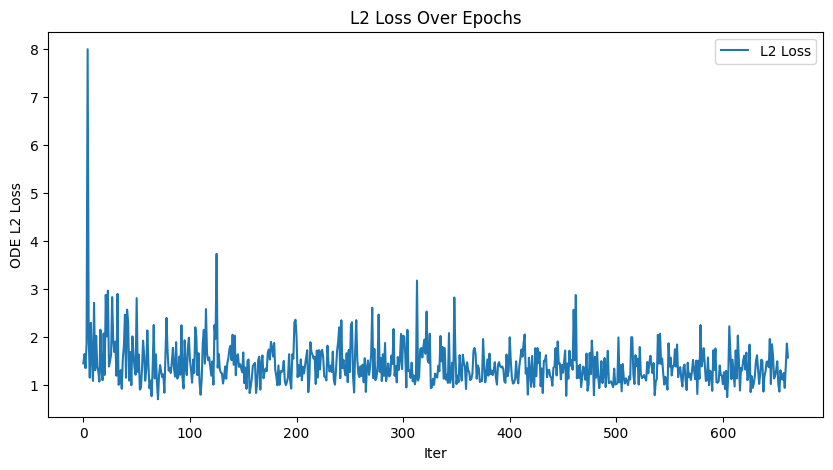

[Epoch 3]  Loss: 2.18762


Epoch 4: 100%|██████████| 662/662 [03:18<00:00,  3.34it/s]


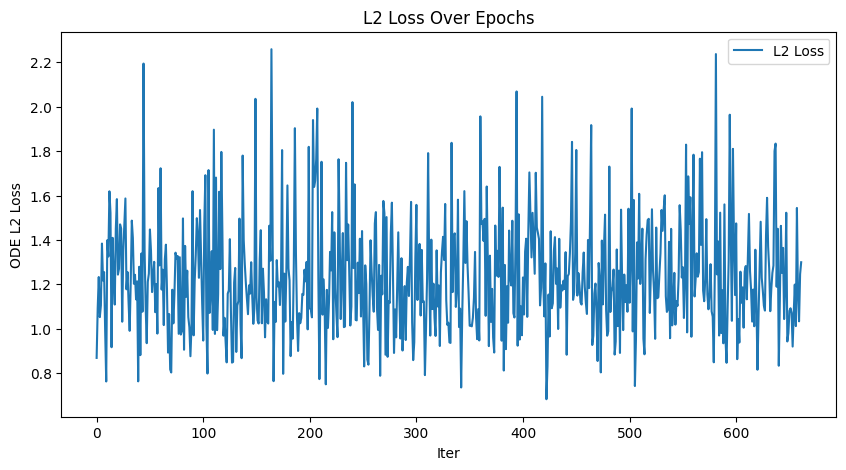

[Epoch 4]  Loss: 2.05165
Finished training!


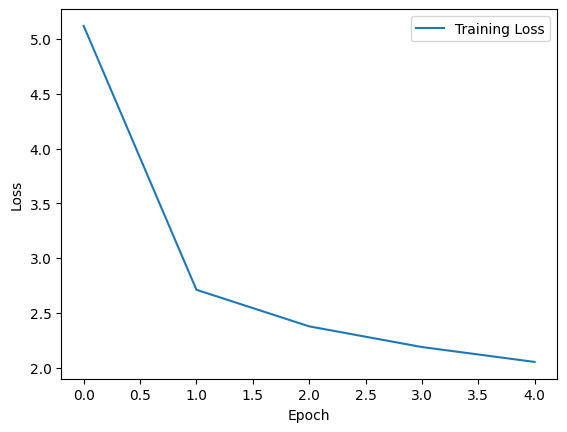

In [40]:
trained_vae = train_vae(adata, mse_weight= 1, 
                            num_epochs=5, batch_size=8)

Folder 'lambda_1' already exists at 'results/lambda_1'.
computing velocity graph (using 1/44 cores)


  0%|          | 0/5292 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


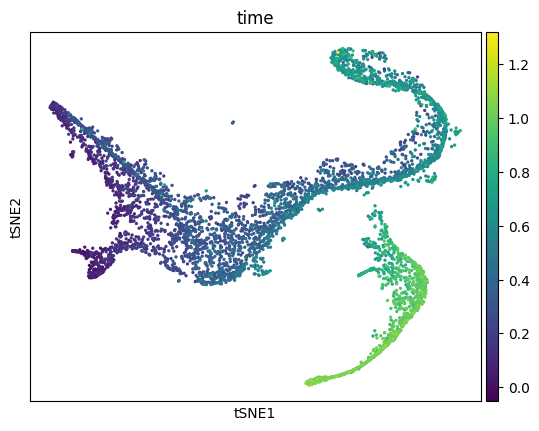

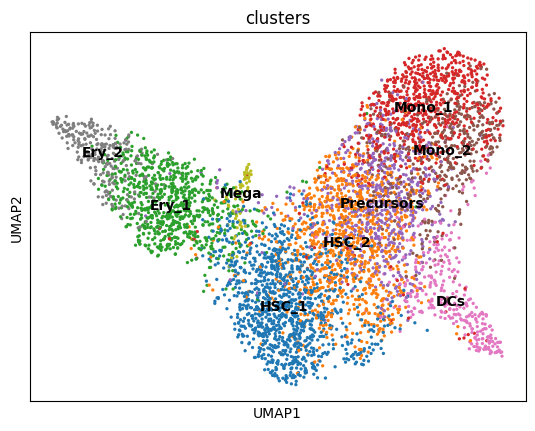

<Figure size 640x480 with 0 Axes>

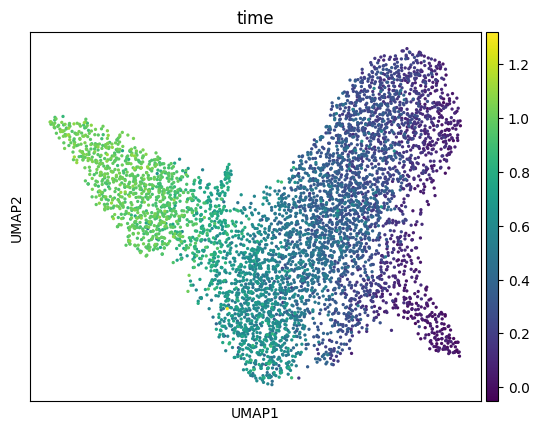

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 640x480 with 0 Axes>

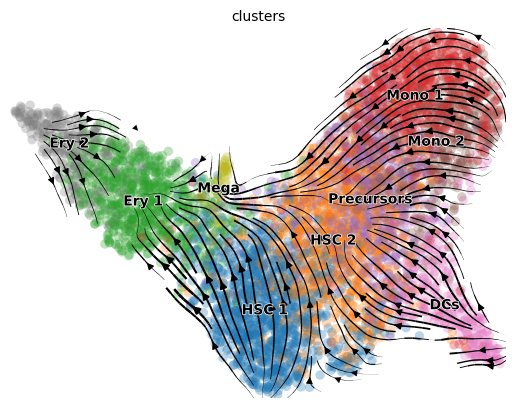

/home/arataz/NDE/lib/python3.10/site-packages/h5py/_hl/attrs.py:104: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.create(name, data=value)
/home/arataz/NDE/lib/python3.10/site-packages/h5py/_hl/filters.py:250: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  chunks = guess_chunk(shape, maxshape, dtype.itemsize)


<Figure size 640x480 with 0 Axes>

In [41]:
process_data_and_save(1, adata, trained_vae, device)